In [2]:
train = '/content/backtranslatedtraining.conll'

In [3]:
!pip install transformers
!pip install tokenizers

In [4]:
def read_conll_train(file_path):
    sentences = []
    current_sentence = []

    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line:
                token, tag = line.split('\t')
                current_sentence.append((token, tag))
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []

    return sentences

train_data = read_conll_train(train)

print(len(train_data))
print(train_data[1200])

1229
[('mar', 'O'), ('a', 'O'), ('bhéas', 'O'), ('a', 'O'), ('shios', 'O'), ('ag', 'O'), ('an', 'O'), ('Teachta', 'O'), ('Ó', 'B-PER'), ('Griffin', 'I-PER'), (',', 'O'), ('i', 'O'), ('Leithinis', 'B-LOC'), ('Bhéarra', 'I-LOC'), ('tá', 'O'), ('an-bheim', 'O'), ('curta', 'O'), ('ar', 'O'), ('an', 'O'), ('bpeil', 'O'), ('.', 'O')]


In [5]:
def read_conll_file(file_path):
    data = []
    current_sentence = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line.startswith('-DOCSTART-'):
                continue
            if line:
                parts = line.split()
                word = parts[0]
                ner_label = parts[-1]
                current_sentence.append((word, ner_label))
            else:
                if current_sentence:
                    data.append(current_sentence)
                    current_sentence = []
    if current_sentence:
        data.append(current_sentence)
    return data


In [6]:
val = '/content/NER_Irish_validation.conll'
test = '/content/NER_Irish_test.conll'
val_data = read_conll_file(val)
test_data = read_conll_file(test)

In [7]:
print(train_data)

[[('\ufeffDáil', 'B-ORG'), ('Éireann', 'I-ORG'), ('06', 'O'), ('/', 'O'), ('07', 'O'), ('/', 'O'), ('2023', 'O')], [('Baineann', 'O'), ('mo', 'O'), ('cheist', 'O'), ('le', 'O'), ('cúrsaí', 'O'), ('tithíochta', 'O'), ('i', 'O'), ('nGaillimh', 'B-LOC'), ('-', 'O'), ('tá', 'O'), ('sé', 'O'), ('níos', 'O'), ('cirte', 'O'), ('easpa', 'O'), ('tithíochta', 'O'), ('i', 'O'), ('nGaillimh', 'B-LOC'), ('a', 'O'), ('rá', 'O'), ('-', 'O'), ('agus', 'O'), ('an', 'O'), ('tascfhórsa', 'O'), ('a', 'O'), ('bunaíodh', 'O'), ('breis', 'O'), ('agus', 'O'), ('ceithre', 'O'), ('bliana', 'O'), ('ó', 'O'), ('shin', 'O')], [('Ar', 'O'), ('dheis', 'O'), ('Dé', 'B-PER'), ('go', 'O'), ('raibh', 'O'), ('a', 'O'), ('anam', 'O')], [('Táim', 'O'), ('os', 'O'), ('comhair', 'O'), ('Dail', 'B-ORG'), ('Éireann', 'I-ORG')], [('Ba', 'O'), ('mhaith', 'O'), ('liom', 'O'), ('tréaslú', 'O'), ('leis', 'O'), ('an', 'O'), ('Teachta', 'O'), ('Andrews', 'B-PER'), ('as', 'O'), ('an', 'O'), ('obair', 'O'), ('atá', 'O'), ('déanta', 'O'

In [8]:
import torch
from transformers import AutoTokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [10]:
tag_values = [
        'O',
        'B-PER',
        'I-PER',
        'B-LOC',
        'I-LOC',
        'B-ORG',
        'I-ORG'
]

tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [11]:
tag2idx

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-LOC': 3,
 'I-LOC': 4,
 'B-ORG': 5,
 'I-ORG': 6,
 'PAD': 7}

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertConfig

In [13]:
MAX_LEN = 256
bs = 32

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [15]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [16]:
train_sent = []

for lst in train_data:
  sent = []
  for words in lst:
    sent.append(words[0])
  train_sent.append(sent)

In [17]:
val_sent = []

for lst in val_data:
  sent = []
  for words in lst:
    sent.append(words[0])
  val_sent.append(sent)

In [18]:
test_sent = []

for lst in test_data:
  sent = []
  for words in lst:
    sent.append(words[0])
  test_sent.append(sent)

In [19]:
train_labels = []

for lst in train_data:
  lab = []
  for words in lst:
    lab.append(words[1])
  train_labels.append(lab)

In [20]:
val_labels = []

for lst in val_data:
  lab = []
  for words in lst:
    lab.append(words[1])
  val_labels.append(lab)

In [21]:
test_labels = []

for lst in test_data:
  lab = []
  for words in lst:
    lab.append(words[1])
  test_labels.append(lab)

In [22]:
print(train_sent[1])

['Baineann', 'mo', 'cheist', 'le', 'cúrsaí', 'tithíochta', 'i', 'nGaillimh', '-', 'tá', 'sé', 'níos', 'cirte', 'easpa', 'tithíochta', 'i', 'nGaillimh', 'a', 'rá', '-', 'agus', 'an', 'tascfhórsa', 'a', 'bunaíodh', 'breis', 'agus', 'ceithre', 'bliana', 'ó', 'shin']


In [23]:
print(train_labels[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [24]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenise the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenised word to the final tokenised word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [25]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sent, train_labels)
]

val_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(val_sent, val_labels)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sent, test_labels)
]

In [26]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_texts_and_labels]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_texts_and_labels]

test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]

In [27]:
print(tokenized_texts)
print(labels)

[['D', '##áil', 'Éireann', '06', '/', '07', '/', '202', '##3'], ['Bai', '##nea', '##nn', 'mo', 'che', '##ist', 'le', 'c', '##úr', '##sa', '##í', 'ti', '##th', '##íocht', '##a', 'i', 'n', '##G', '##ail', '##lim', '##h', '-', 'tá', 'sé', 'níos', 'ci', '##rte', 'ea', '##sp', '##a', 'ti', '##th', '##íocht', '##a', 'i', 'n', '##G', '##ail', '##lim', '##h', 'a', 'rá', '-', 'agus', 'an', 'tas', '##c', '##f', '##h', '##ór', '##sa', 'a', 'buna', '##íodh', 'br', '##eis', 'agus', 'cei', '##th', '##re', 'bli', '##ana', 'ó', 'shi', '##n'], ['Ar', 'dhe', '##is', 'D', '##é', 'go', 'raibh', 'a', 'ana', '##m'], ['Tá', '##im', 'os', 'com', '##hair', 'Dai', '##l', 'Éireann'], ['Ba', 'm', '##hai', '##th', 'li', '##om', 'tr', '##éa', '##sl', '##ú', 'leis', 'an', 'Tea', '##chta', 'Andrews', 'as', 'an', 'oba', '##ir', 'atá', 'dé', '##anta', 'aige', 'sa', 'phí', '##osa', 'reach', '##ta', '##íocht', '##a', 'seo', 'mar', 'is', 'é', 'a', 'rin', '##ne', 'form', '##h', '##ór', 'na', 'ho', '##ib', '##re', 'u', '##i

In [28]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [29]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [30]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]

test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]

In [31]:
tr_inputs = torch.tensor(input_ids)
tr_tags = torch.tensor(tags)
tr_masks = torch.tensor(attention_masks)

vl_inputs = torch.tensor(val_input_ids)
vl_tags = torch.tensor(val_tags)
vl_masks = torch.tensor(val_attention_masks)

tst_inputs = torch.tensor(test_input_ids)
tst_tags = torch.tensor(test_tags)
tst_masks = torch.tensor(test_attention_masks)

In [32]:
tr_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(tr_data)
train_dataloader = DataLoader(tr_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(vl_inputs, vl_masks, vl_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

tst_data = TensorDataset(tst_inputs, tst_masks, tst_tags)
tst_sampler = SequentialSampler(tst_data)
tst_dataloader = DataLoader(tst_data, sampler=tst_sampler, batch_size=bs)

In [33]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, AdamW

In [34]:
model_name = 'bert-base-multilingual-cased'
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model.cuda();

In [36]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=41796dfcb02eade62e7968c2ff017d6a468e606721645221ee88c793cd7897f3
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [38]:
from seqeval.metrics import f1_score, accuracy_score

In [39]:
from tqdm import tqdm, trange

import numpy as np

In [40]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [41]:
from sklearn.metrics import classification_report

In [42]:
## Store the average loss after each epoch so we can plot them
loss_values, validation_loss_values = [], []
best_model_state = None
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0
best_epoch = 0

for epoch in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set

    # Put the model into training mode
    model.train()
    # Reset the total loss for this epoch
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
   # val_report = classification_report(valid_tags, pred_tags)
   # print("Epoch {} - Validation Classification Report:".format(epoch))
   # print(val_report)
    if eval_loss < best_val_loss:
      best_val_loss = eval_loss
      best_epoch = epoch
      best_model_state = model.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print(f"Validation loss hasn't improved for {patience} epochs. Best model found at epoch {best_epoch}.")
          break

    print("Epoch {} - Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch, avg_train_loss, eval_loss))
    print()

# Output the best epoch model
if best_model_state is not None:
    torch.save(best_model_state, "final_mbert_V3.pt")
    print("Best model saved to 'final_mbert_V3.pt'.")


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.33021043164607805


Epoch:  10%|█         | 1/10 [00:51<07:41, 51.31s/it]

Validation loss: 0.09601760655641556
Validation Accuracy: 0.8403781979977754
Epoch 0 - Training Loss: 0.3302, Validation Loss: 0.0960

Average train loss: 0.08862155991104934


Epoch:  20%|██        | 2/10 [01:45<07:01, 52.71s/it]

Validation loss: 0.06420595105737448
Validation Accuracy: 0.9056358917315536
Epoch 1 - Training Loss: 0.0886, Validation Loss: 0.0642

Average train loss: 0.05639304526341267


Epoch:  30%|███       | 3/10 [02:39<06:15, 53.68s/it]

Validation loss: 0.05567191354930401
Validation Accuracy: 0.9171301446051168
Epoch 2 - Training Loss: 0.0564, Validation Loss: 0.0557

Average train loss: 0.038939508776634164


Epoch:  40%|████      | 4/10 [03:34<05:24, 54.02s/it]

Validation loss: 0.04969661310315132
Validation Accuracy: 0.9265850945494994
Epoch 3 - Training Loss: 0.0389, Validation Loss: 0.0497

Average train loss: 0.028974829480434075


Epoch:  50%|█████     | 5/10 [04:28<04:30, 54.19s/it]

Validation loss: 0.05142182903364301
Validation Accuracy: 0.931961438635521
Epoch 4 - Training Loss: 0.0290, Validation Loss: 0.0514

Average train loss: 0.022126049280930787


Epoch:  50%|█████     | 5/10 [05:23<05:23, 64.69s/it]

Validation loss: 0.058282924350351095
Validation Accuracy: 0.931961438635521
Validation loss hasn't improved for 2 epochs. Best model found at epoch 3.


Best model saved to 'final_mbert_V3.pt'.


In [43]:
print(epochs)

10


In [44]:
print(range(1, 6))

range(1, 6)


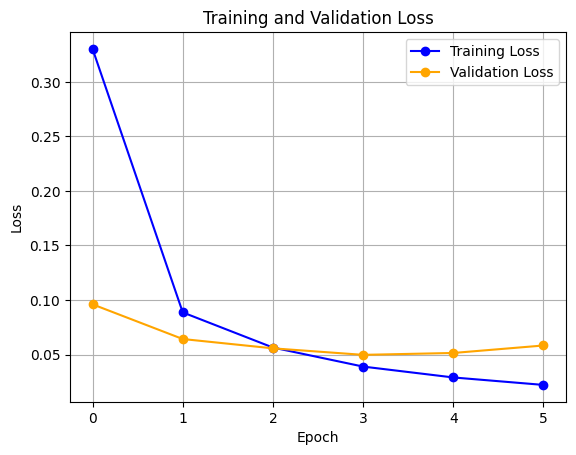

In [45]:
import matplotlib.pyplot as plt

# Generate x-axis values (epochs)
epochs = range(len(loss_values) + 1)

# Plotting with markers and lines
plt.plot(epochs[:-1], loss_values, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs[:-1], validation_loss_values, marker='o', linestyle='-', label='Validation Loss', color='orange')

# Labelling and styling
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set ticks for x-axis (epochs) to whole numbers only starting from 0
plt.xticks(epochs[:-1])


# Ensure y-axis (loss) ticks are whole numbers only
#plt.yticks(range(int(min(min(loss_values), min(validation_loss_values))), int(max(max(loss_values), max(validation_loss_values))) + 1))
plt.savefig('/content/mbert_V3_training_validation_loss_plot.png')
# Show plot
plt.grid(True)
plt.show()


In [46]:
PATH = '/content/drive/MyDrive/mBERT/mbert_v3.pt'
torch.save(model.state_dict(), PATH)

In [47]:
model.eval()

predicted_labels = []
true_labels = []

# Iterate through the test_dataloader to get the predictions
# Using the GPU
for batch in tst_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        outputs = model(**inputs)

    # Extracting the predictions and also the true labels for the test data
    predicted_labels.extend(outputs.logits.argmax(dim=-1).tolist())
    true_labels.extend(inputs['labels'].tolist())

In [48]:
print(predicted_labels)
print(true_labels)

[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [49]:
i = 0
while i < len(true_labels):
  if len(true_labels[i]) != len(predicted_labels[i]):
    print('issue')
    i += 1
  i += 1

In [50]:
preds = []
trues = []

for sentences in true_labels:
  t = []
  for vals in sentences:
    if vals != 7:
      t.append(vals)
  trues.append(t)

for sentences in predicted_labels:
  p = []
  for vals in sentences:
    if vals != 7:
      p.append(vals)
  preds.append(p)

print(trues)
print(preds)

[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [51]:
print(test_tokenized_texts)
print(test_labels)
print(preds)

[['Mar', 'a', 't', '##ch', '##ít', '##ear', 'do', 'She', '##osa', '##mh', 'Mac', 'G', '##rian', '##na', 'é', 'cai', '##th', '##fi', '##dh', 'an', 't', '-', 'ea', '##la', '##ío', '##ntó', '##ir', 'an', 'sola', '##s', 'a', 'tha', '##bh', '##air', '##t', 'don', 'sao', '##l', 'agus', 'di', '##úl', '##tú', 'do', 'chat', '##h', '##ú', 'sin', 'na', 'tr', '##uai', '##ll', '##íocht', '##a', 'a', 'chu', '##irea', '##nn', 'an', 'sao', '##l', 'ina', 'cho', '##s', '##án', '.'], ['D', '##hi', '##úl', '##tai', '##gh', 'Johna', '##tha', '##n', 'Cape', 'agus', 'c', '##úp', '##la', 'foi', '##ls', '##ithe', '##oir', 'eile', 'an', 'lea', '##bhar', 'a', 'f', '##ho', '##ils', '##i', '##ú', 'agus', 'bhí', 'Naomi', 'le', 'cea', '##nga', '##l', 'go', 'raibh', 's', '##rian', 'a', 'chur', 'ar', 'a', 'cui', '##d', 'tua', '##iri', '##mí', '##ocht', '##a', '.'], ['G', '##rian', '##gh', '##rai', '##f', 'le', 'Mai', '##dh', '##c', 'Ó', 'Sea', '##chn', '##asa', '##í', '.'], ['Tag', '##ann', 'a', 'rá', '##ite', '##as',

In [52]:
i = 0
while i < len(preds):
  if len(test_labels[i]) != len(preds[i]):
    print('issue')
    i += 1
  i += 1

In [53]:
import pandas as pd

label_map = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-LOC',
    4: 'I-LOC',
    5: 'B-ORG',
    6: 'I-ORG'
}

# Initialise an empty list to store DataFrames
dfs = []

# Iterate through the tokens, labels, and predictions
for tokens, labels, predictions in zip(test_tokenized_texts, test_labels, preds):
    # Create a DataFrame from the current sublist
    temp_df = pd.DataFrame({'Word': tokens, 'POS': 'X', 'True': labels, 'Predicted': [label_map[pred] for pred in predictions]})
    # Append the DataFrame to the list
    dfs.append(temp_df)
    # Add an empty row as a DataFrame to the list
    dfs.append(pd.DataFrame({'Word': [''], 'POS': [''], 'True': [''], 'Predicted': ['']}))

# Concatenate the DataFrames along the rows axis
df = pd.concat(dfs, ignore_index=True)

print(df)

        Word POS   True Predicted
0        Mar   X      O         O
1          a   X      O         O
2          t   X      O         O
3       ##ch   X      O         O
4       ##ít   X      O         O
...      ...  ..    ...       ...
7930      Ga   X  B-LOC     B-LOC
7931  ##elta   X  B-LOC     B-LOC
7932   ##cht   X  B-LOC     B-LOC
7933     ann   X      O         O
7934                             

[7935 rows x 4 columns]


In [54]:
print(df.head(2395))

        Word POS True Predicted
0        Mar   X    O         O
1          a   X    O         O
2          t   X    O         O
3       ##ch   X    O         O
4       ##ít   X    O         O
...      ...  ..  ...       ...
2390     com   X    O         O
2391    ##ór   X    O         O
2392  ##tais   X    O         O
2393     seo   X    O         O
2394       .   X    O         O

[2395 rows x 4 columns]


In [55]:
conll_format = ""

for index, row in df.iterrows():
    text = row['Word']
    pos = row['POS']
    tag = row['True']
    mapped_tag = row['Predicted']

    # Append the token in CoNLL format (word, POS, gold_label, predicted_label)
    conll_format += f"{text}\t{pos}\t{tag}\t{mapped_tag}\n"

# Write the CoNLL format string to a text file
with open('/content/final_mBERT_for_eval_V3.conll', 'w') as f:
    f.write(conll_format)